In [63]:
import sys
import os
sys.path.append(os.path.abspath("../.."))
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from tinyshift.outlier import HBOS, SPAD, PCAReconstructionError
from tinyshift.tracker import AnomalyTracker
from sklearn.model_selection import train_test_split
from tinyshift.series import hampel_filter
import plotly.express as px

In [64]:

weights = [0.2, 0.8]

X, y = make_classification(
    n_samples=100000, 
    n_features=20, 
    n_informative=2,      
    weights=weights, 
    random_state=42,
    n_redundant=2)

num_samples = X.shape[0]

categorical_col1 = np.random.choice(['A', 'B', 'C'], size=num_samples)
categorical_col2 = np.random.choice(['X', 'Y', 'Z'], size=num_samples)

df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['cat1'] = categorical_col1
df['cat2'] = categorical_col2
df["cat1"] = df["cat1"].astype("category").cat.rename_categories({"A": 0, "B": 1, "C": 2})
df["cat2"] = df["cat2"].astype("category").cat.rename_categories({"Z": 0, "Y": 1, "X": 2})

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

## HBOS

In [65]:
hbos = HBOS(dynamic_bins=True)
hbos.fit(df_train, nbins="fd")

,dynamic_bins,True


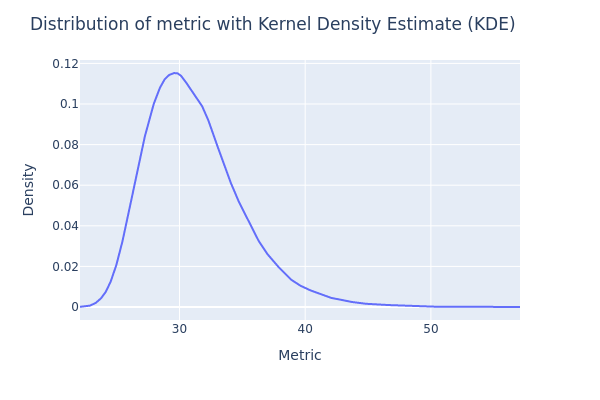

In [66]:
tracker = AnomalyTracker(hbos, drift_limit=("quantile", None, 0.99))
tracker.plot.kde(fig_type="png")

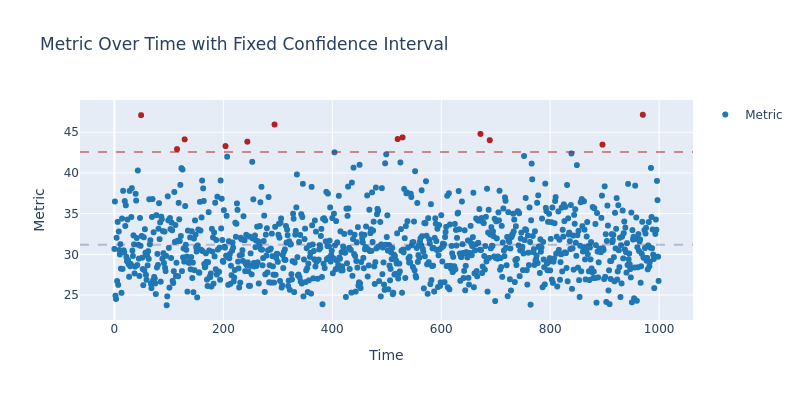

In [67]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

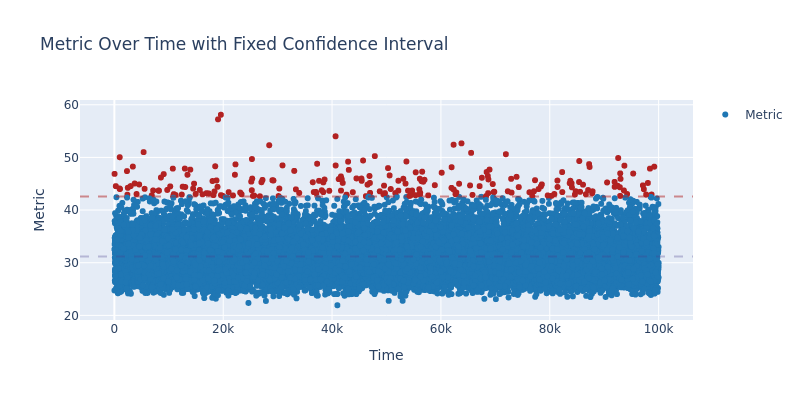

In [68]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

In [69]:
assert np.sum(tracker.predict(df_test)) == np.sum(hbos.predict(df_test))

## SPAD

In [70]:
spad = SPAD()
spad.fit(df_train, nbins="fd", method="mad")

,plus,False


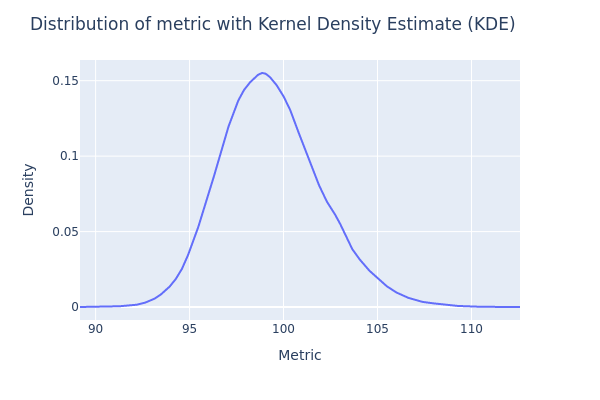

In [71]:
tracker = AnomalyTracker(spad, drift_limit=("quantile", None, 0.99))
tracker.plot.kde(fig_type="png")

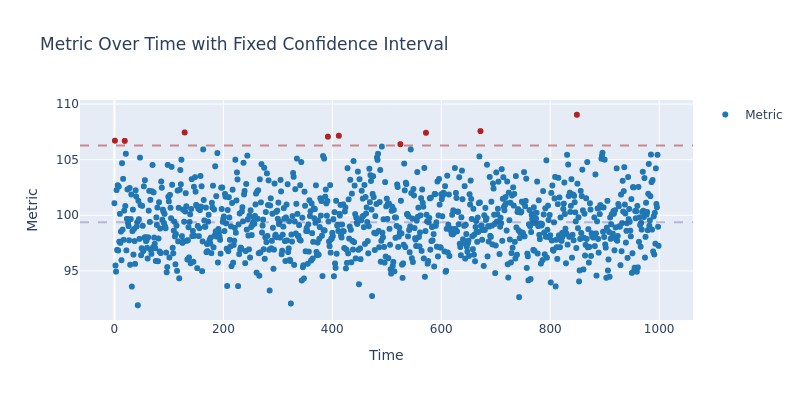

In [72]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

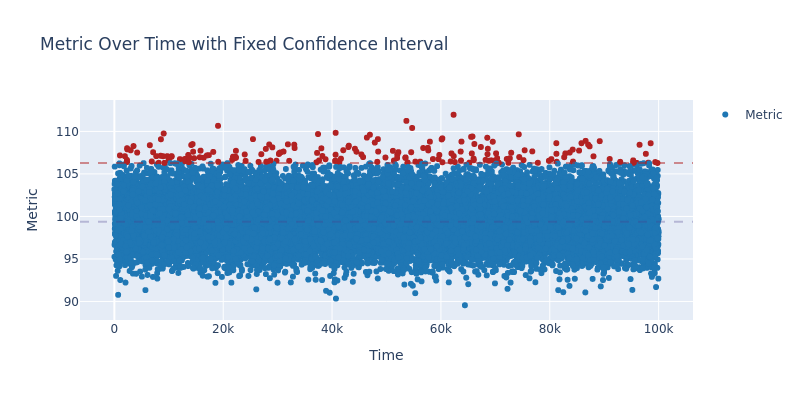

In [73]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

In [74]:
assert np.sum(tracker.predict(df_test)) == np.sum(spad.predict(df_test))

## SPAD+

In [75]:
spad_plus = SPAD(plus=True)
spad_plus.fit(df_train)

,plus,True


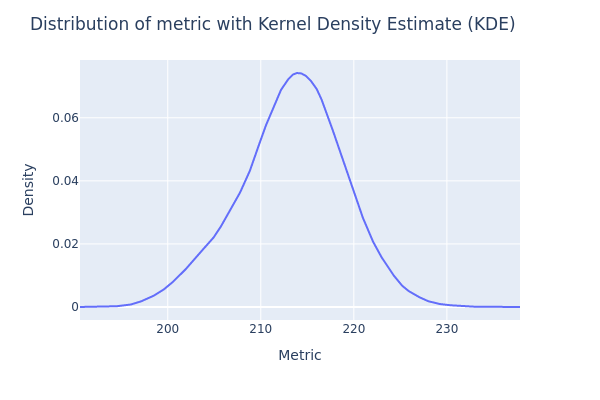

In [76]:
tracker = AnomalyTracker(spad_plus, drift_limit=("quantile", None, 0.99))
tracker.plot.kde(fig_type="png")

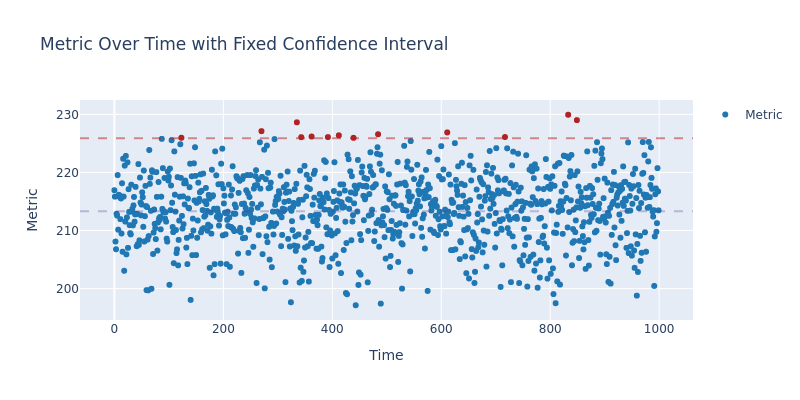

In [77]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

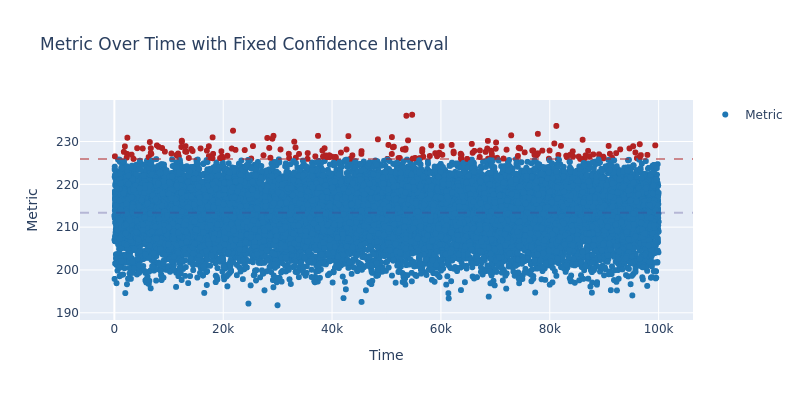

In [78]:
scored = tracker.score(df_test)
tracker.plot.scatter(scored, fig_type="png")

In [79]:
assert np.sum(tracker.predict(df_test)) == np.sum(spad_plus.predict(df_test))

# PCAReconstructionError

In [80]:
model = PCAReconstructionError()
model.fit(df_train.loc[:, ~df_train.columns.isin(['cat1', 'cat2'])])

PCAReconstructionError()

In [81]:
def percentile_threshold(data: pd.DataFrame):
    """Calculates thresholds using the 99th percentiles."""
    lower_limit = None
    upper_limit = np.percentile(data, 99, method="higher")
    return lower_limit, upper_limit

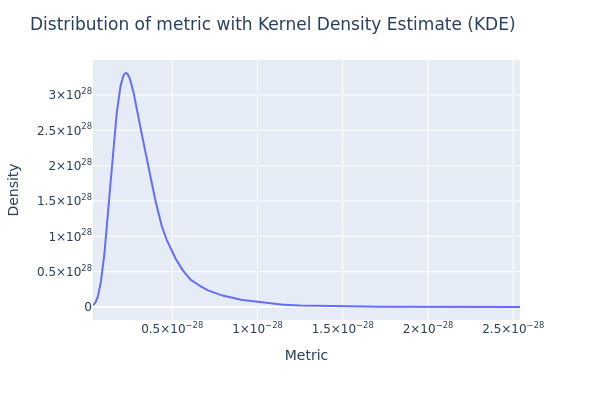

In [82]:
tracker = AnomalyTracker(model, drift_limit=percentile_threshold)
tracker.plot.kde(fig_type="png")

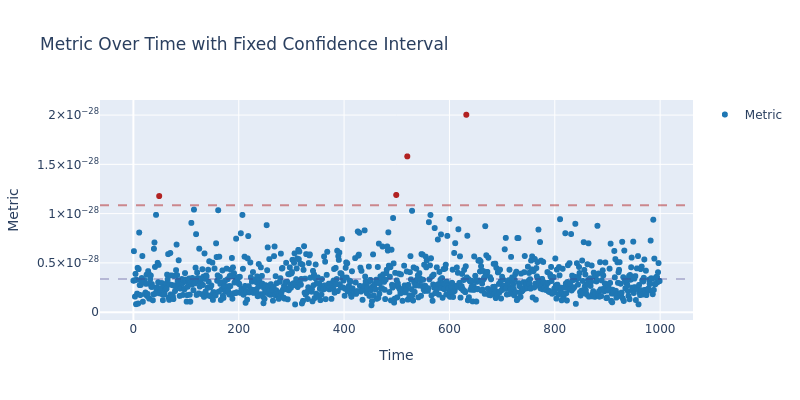

In [83]:
tracker.plot.scatter(tracker.anomaly_scores[:1000], fig_type="png")

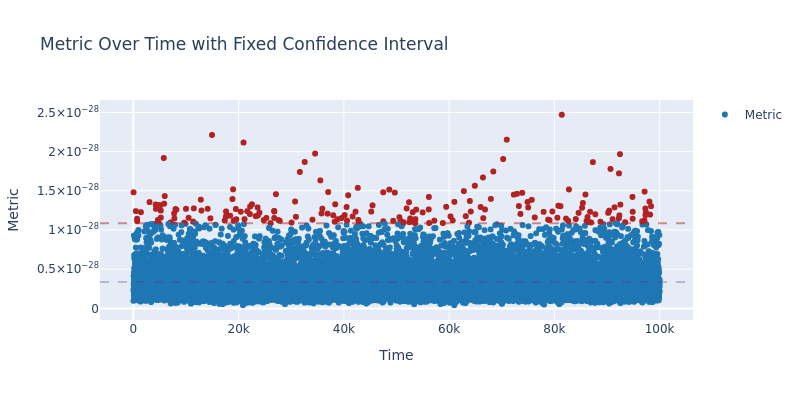

In [84]:
scored = tracker.score(df_test.loc[:, ~df_test.columns.isin(['cat1', 'cat2'])])
tracker.plot.scatter(scored, fig_type="png")

In [85]:
assert np.sum(tracker.predict(df_test.loc[:, ~df_test.columns.isin(['cat1', 'cat2'])])) == np.sum(model.predict(df_test.loc[:, ~df_test.columns.isin(['cat1', 'cat2'])]))

# Hampel Filter

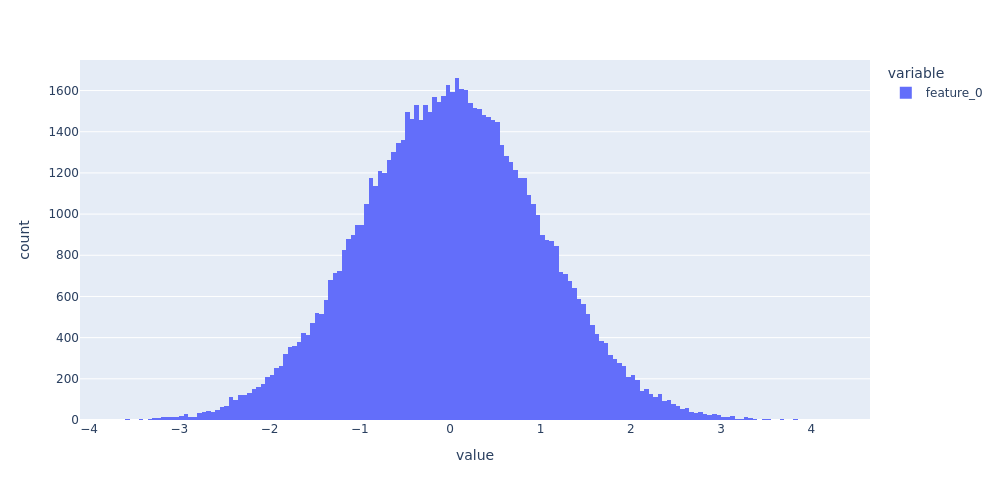

In [86]:
fig = px.histogram(df_train["feature_0"])
fig.show("png", width=1000)

In [87]:
mask = hampel_filter(df_train["feature_0"], rolling_window=31)

In [88]:
mask

array([False, False, False, ..., False, False, False], shape=(80000,))

In [89]:
df_train[mask]

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,cat1,cat2
52795,2.249811,1.769962,-1.133707,-1.092061,2.132263,0.675658,1.794896,-0.209883,0.088248,1.862140,...,-0.482956,-0.094769,2.006993,-0.015849,0.923930,1.985005,-1.661885,-0.830211,0,2
63509,-1.700386,0.310031,1.020469,0.561973,1.941331,-1.053395,0.875382,-0.562172,-0.185595,1.637448,...,0.854262,0.202537,-0.516156,1.390298,0.820246,-0.301861,-1.608119,-0.715477,1,1
18305,3.275712,-0.330931,-0.681957,-1.000313,1.211448,-1.598008,1.178794,-0.519731,1.233146,3.383114,...,0.240360,0.981985,0.797859,0.825664,1.147904,2.181968,2.869432,-0.557981,1,0
93541,-2.617944,-1.215280,1.138909,0.057781,0.514659,0.628937,0.165770,0.227630,-0.186650,1.033453,...,-1.149154,-1.464689,-0.868170,-0.427337,-1.433856,-0.357814,0.556726,-0.177873,2,2
81204,-3.152698,-0.292751,0.158583,-0.153290,-0.911454,-1.881228,-0.465879,0.414919,-0.977661,-0.484612,...,0.640820,0.054296,-0.477392,0.024903,-0.282346,1.291195,1.221097,-0.130863,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90272,3.824992,-0.776902,1.138167,0.470020,-0.085914,0.687675,-0.194048,0.123542,0.347932,-1.055155,...,-0.761483,-1.060512,0.269134,-0.055415,-0.101634,-0.306009,-1.540617,0.762117,1,1
94179,3.329940,-1.380274,-0.659775,0.730667,-0.206522,-1.356045,-1.665993,-0.360154,0.635125,-0.265886,...,0.570982,-0.332362,-0.021239,0.168183,1.498932,-0.226665,0.020684,0.479702,2,1
50859,-2.589795,-0.232267,-0.954487,1.670590,1.292465,0.423638,-0.253321,1.437519,0.825140,1.387005,...,3.489848,-0.728712,-0.111361,0.652907,1.610334,-0.552116,-0.583731,0.347285,0,2
8392,-2.133624,-2.142353,0.221636,0.810008,-0.743554,-1.410799,-0.177610,-0.091637,0.482689,-1.541899,...,1.562888,0.874327,0.602895,-0.611166,0.461044,0.349691,-0.884398,0.715821,0,0
